# Recommendations in pytorch using triplet loss
Along the lines of BPR [1]. 

[1] Rendle, Steffen, et al. "BPR: Bayesian personalized ranking from implicit feedback." Proceedings of the Twenty-Fifth Conference on Uncertainty in Artificial Intelligence. AUAI Press, 2009.

This is implemented (more efficiently) in LightFM (https://github.com/lyst/lightfm). See the MovieLens example (https://github.com/lyst/lightfm/blob/master/examples/movielens/example.ipynb) for results comparable to this notebook.

## Set up the architecture
A simple dense layer for both users and items: this is exactly equivalent to latent factor matrix when multiplied by binary user and item indices. There are three inputs: users, positive items, and negative items. In the triplet objective we try to make the positive item rank higher than the negative item for that user.

Because we want just one single embedding for the items, we use shared weights for the positive and negative item inputs (a siamese architecture).

This is all very simple but could be made arbitrarily complex, with more layers, conv layers and so on. I expect we'll be seeing a lot of papers doing just that.


In [1]:
from __future__ import print_function

import numpy as np
import itertools
import data
import metrics
from time import time

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from functools import partial
from itertools import chain

In [2]:
n_latent = 20
batch_size = 64

# Read data
train, test = data.get_movielens_data()
train = train.tocsr()
n_users, n_items = train.shape
print(n_users, n_items)

944 1683


In [3]:
class FactNet(nn.Module):
    def __init__(self,
                 n_users, n_items,
                 n_latent,
                ):
        super(FactNet, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_latent = n_latent
        self.user_embedding_layer = nn.Embedding(self.n_users, self.n_latent)
        self.item_embedding_layer = nn.Embedding(self.n_items, self.n_latent)  # both pos and neg items share these params
        init.uniform(self.user_embedding_layer.weight, -0.5, 0.5)
        init.uniform(self.item_embedding_layer.weight, -0.5, 0.5)  # default was normal
        
    def predict_score(self, uid, iid):
        user_embedding = self.user_embedding_layer(uid)
        item_embedding = self.item_embedding_layer(iid)
        score = (user_embedding * item_embedding).sum(dim=1)
        return score
    
        
    def forward(self, uid, pid, nid):
        # lulzy forward for loss computation
        user_embedding = self.user_embedding_layer(uid)
        pos_item_embedding = self.item_embedding_layer(pid)
        neg_item_embedding = self.item_embedding_layer(nid)
        
        # torch.dot doesnt take in axis :sadface:
        pos_pred = (user_embedding * pos_item_embedding).sum(dim=1)
        neg_pred = (user_embedding * neg_item_embedding).sum(dim=1)
        return pos_pred, neg_pred

    
class TripletLoss(nn.Module):
    def __init__(self, loss='hinge', warp_weighting=True, n_items=None):
        super(TripletLoss, self).__init__()
        self.n_items = n_items
        loss_d = {
            'sigmoid': self.forward_sigmoid,
            'hinge': self.forward_hinge,
        }
        if warp_weighting:
            self.forward_premean = lambda pos_pred, neg_pred, nsamp: \
                self.warp_weight(nsamp) * loss_d[loss](pos_pred, neg_pred)
        else:
            self.forward_premean = lambda pos_pred, neg_pred, nsamp: \
                loss_d[loss](pos_pred, neg_pred)
        
    def forward(self, *args):
        return self.forward_premean(*args).mean()
        
    def warp_weight(self, nsamp):
        return torch.log(torch.floor((self.n_items-1)/nsamp)) / np.log(self.n_items)
    
    def forward_sigmoid(self, pos_pred, neg_pred):
        loss = 1.0 - torch.sigmoid(pos_pred - neg_pred)
        return loss
    
    def forward_hinge(self, pos_pred, neg_pred):
        loss = torch.clamp(1.0 + neg_pred - pos_pred, min=0.0)
        return loss


net = FactNet(n_users, n_items, n_latent)
criterion = TripletLoss(loss='hinge', warp_weighting=True, n_items=n_items)
# optimizer = optim.Adam(net.parameters())
# optimizer = optim.Adadelta(net.parameters())
optimizer = optim.Adagrad(net.parameters())

In [4]:
def batcher(iterable, batch_size):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, batch_size))
        if not chunk:
            return
        yield np.array(chunk, dtype=np.int64)

In [5]:
from bisect import bisect_left

def bsearch_membership(csr_mat, row_ind, col_ind):
    """ ehh, this is slower than `in`
    csr_mat : interaction matrix
    row_ind : user_ind
    col_ind : item_ind
    """
    start_idx = csr_mat.indptr[row_ind]
    stop_idx = csr_mat.indptr[row_ind+1]
    pos_vals = csr_mat.indices[start_idx:stop_idx]
    insertion_index = bisect_left(pos_vals, col_ind)
    return (insertion_index < (stop_idx-start_idx)) and (col_ind == pos_vals[insertion_index])

def get_row_nz(csr_mat, col_ind):
    """faster than csr_mat.get_row for some reason"""
    start_idx = csr_mat.indptr[col_ind]
    stop_idx = csr_mat.indptr[col_ind+1]
    return csr_mat.indices[start_idx:stop_idx]
    

# Negative sample generator

def sample_neg(user_ind, interactions,
               max_samples=100,
               violating_cond=lambda neg_item_ind:True):
    # Given a user index, sample a negative item
#     user_pos_item_inds = interactions.getrow(user_ind).nonzero()[1]  # much too slow
    user_pos_item_inds = get_row_nz(interactions, user_ind)
    
    n_sampled = 0
    while n_sampled < max_samples:
        neg_item_ind = np.random.randint(0, n_items)
        n_sampled += 1
        if neg_item_ind not in user_pos_item_inds:
            if violating_cond(neg_item_ind):
                break  # will go and use this sample
    return neg_item_ind, n_sampled


def violation_warp(neg_item_ind, user_tensor, pos_score, net):
    items_input = Variable(torch.LongTensor([neg_item_ind]))
    neg_score = net.predict_score(user_tensor, items_input)
    condition_var = neg_score > pos_score - 1.
    # Need to extract the data from the Var for logical bool
    return torch.max(condition_var.data)


def sample_warp(interactions, net):
    nnz_users, nnz_items = map(np.int64, interactions.nonzero())
    user_input = Variable(torch.LongTensor(nnz_users))
    pos_item_input = Variable(torch.LongTensor(nnz_items))
    pos_scores = net.predict_score(user_input, pos_item_input)
    
    nid_preload = []
    n_sampled_preload = []
    for uid, user_tensor, pos_score in zip(nnz_users, user_input, pos_scores):
        nid, nsamp = sample_neg(
            uid, interactions, 
            violating_cond=partial(violation_warp, 
                                   user_tensor=user_tensor, 
                                   pos_score=pos_score, 
                                   net=net))
        nid_preload.append(nid)
        n_sampled_preload.append(nsamp)
        
    return nid_preload, n_sampled_preload

In [6]:
%%time
# Sample from training interactions
nnz_users, nnz_items = map(np.int64, train.nonzero())

shuffle_ind = np.arange(len(nnz_users))

# preload at the start of every epoch
# (next epoch can be preloaded using cpu while gpu trains if the net is shared)
nid_preload, n_sampled_preload = sample_warp(train, net)

CPU times: user 7.13 s, sys: 84 ms, total: 7.22 s
Wall time: 4.52 s


In [7]:
%%time
num_epochs = 20
avg_nsamps = []
tocs = []
for epoch in range(num_epochs):
    print('Epoch %d' % epoch, end='\t')
    tic = time()
    
    # Resample negs per pos interaction
    nid_preload, n_sampled_preload = map(np.array, sample_warp(train, net))

    np.random.shuffle(shuffle_ind)

    uid_gen = batcher(nnz_users[shuffle_ind], batch_size)
    pid_gen = batcher(nnz_items[shuffle_ind], batch_size)
    nid_gen = batcher(nid_preload[shuffle_ind], batch_size)
    n_samp_gen = batcher(n_sampled_preload[shuffle_ind], batch_size)
    avg_nsamps_b = []
    for uid_batch, pid_batch, nid_batch, nsamp_batch in zip(uid_gen, pid_gen, nid_gen, n_samp_gen):
        user_input = Variable(torch.LongTensor(uid_batch))
        p_item_input = Variable(torch.LongTensor(pid_batch))
        n_item_input = Variable(torch.LongTensor(nid_batch))
        nsamp_input = Variable(torch.FloatTensor(nsamp_batch))
        pos_pred, neg_pred = net(user_input, p_item_input, n_item_input)
        loss = criterion(pos_pred, neg_pred, nsamp_input)
        loss.backward()
        optimizer.step()
        avg_nsamps_b.append(nsamp_batch)
        
    toc = time() - tic
    avg_nsamps.append(np.mean(list(chain(*avg_nsamps_b))))
    tocs.append(toc)
    
    print('AUC: train:{}\t test:{}'\
          .format(metrics.full_auc_pytorch(net, train),
                  metrics.full_auc_pytorch(net, test),
                 ))
    
    print('avg nsamp:{} \t time:{}'.format(avg_nsamps[-1], tocs[-1]))

Epoch 0		AUC: train:0.804675422952	 test:0.698668994468
avg nsamp:1.10856410051 	 time:5.12060308456
Epoch 1		AUC: train:0.908110871777	 test:0.828589238891
avg nsamp:7.65719552759 	 time:24.3163590431
Epoch 2		AUC: train:0.933084519728	 test:0.85752300792
avg nsamp:21.0292149241 	 time:64.241286993
Epoch 3		AUC: train:0.945215041587	 test:0.869739011746
avg nsamp:25.2253837214 	 time:76.6893680096
Epoch 4		AUC: train:0.953289733134	 test:0.879337713435
avg nsamp:27.0332024206 	 time:81.804019928
Epoch 5		AUC: train:0.958571955284	 test:0.885195985652
avg nsamp:31.1956077426 	 time:94.1827380657
Epoch 6		AUC: train:0.961578843569	 test:0.887316457402
avg nsamp:34.4481825833 	 time:103.758337021
Epoch 7		AUC: train:0.963488563086	 test:0.887488449733
avg nsamp:36.0002805274 	 time:108.203058004
Epoch 8		AUC: train:0.964939686769	 test:0.887765256806
avg nsamp:36.9745120827 	 time:111.449014902
Epoch 9		AUC: train:0.966455853553	 test:0.888851915736
avg nsamp:37.5568468721 	 time:112.421

# Plots

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

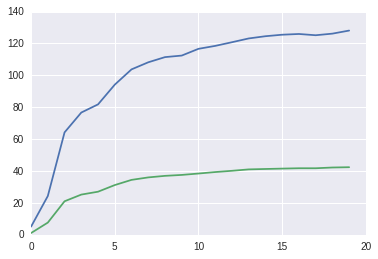

In [10]:
plt.plot(range(num_epochs), tocs)
plt.plot(range(num_epochs), avg_nsamps)